<a href="https://colab.research.google.com/github/stochasticats/plantpathologyfgvc7-keras-deeplearning/blob/master/plantpathologyfgvc7_keras_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import shutil

1.15.0


# Load data and preprocessing
Here we load the data and process it so that it can be fed into the model. The data set is a zipped file located on my Google drive.

In [0]:
!unzip -uq "/content/drive/My Drive/plant-pathology-2020-fgvc7.zip"

In [0]:
dataset = pd.read_csv('train.csv')
print(dataset.head())
print(dataset.shape)

  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0
(1821, 5)


In [0]:
dataset.describe()

,healthy,multiple_diseases,rust,scab
count,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.283361,0.049973,0.341571,0.325096
std,0.450754,0.217948,0.474367,0.468539
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


The data set is clearly imbalanced in one of the classes, that class being multiple_diseases. It's safe to say most of the plants are either healthy, scabby, or rusty. 

Now to split the data into train and validation sets, then take a quick look at their make up.

In [0]:
train, validation = train_test_split(dataset, test_size=0.2)

In [0]:
print(train.head())
print(validation.head())

        image_id  healthy  multiple_diseases  rust  scab
776    Train_776        1                  0     0     0
662    Train_662        0                  0     0     1
1390  Train_1390        0                  1     0     0
205    Train_205        0                  0     1     0
1185  Train_1185        0                  0     1     0
        image_id  healthy  multiple_diseases  rust  scab
584    Train_584        0                  0     1     0
301    Train_301        0                  0     1     0
598    Train_598        0                  0     1     0
1377  Train_1377        1                  0     0     0
1670  Train_1670        1                  0     0     0


In [0]:
print(train.describe())
print(validation.describe())

           healthy  multiple_diseases         rust         scab
count  1456.000000        1456.000000  1456.000000  1456.000000
mean      0.278846           0.050824     0.344093     0.326236
std       0.448586           0.219714     0.475235     0.468996
min       0.000000           0.000000     0.000000     0.000000
25%       0.000000           0.000000     0.000000     0.000000
50%       0.000000           0.000000     0.000000     0.000000
75%       1.000000           0.000000     1.000000     1.000000
max       1.000000           1.000000     1.000000     1.000000
          healthy  multiple_diseases        rust        scab
count  365.000000         365.000000  365.000000  365.000000
mean     0.301370           0.046575    0.331507    0.320548
std      0.459483           0.211017    0.471401    0.467328
min      0.000000           0.000000    0.000000    0.000000
25%      0.000000           0.000000    0.000000    0.000000
50%      0.000000           0.000000    0.000000    0.0000

Here I write code to put the images into a sorted directory based on their class so it is easier to use ImageDataGenerator.

In [0]:
ground_truth = train
folder = os.listdir('/content/unsorted_images')
train_list = list(ground_truth['image_id'])
base_dir = 'images'
os.mkdir(base_dir)
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
healthy = os.path.join(train_dir, 'healthy')
os.mkdir(healthy)
multiple_diseases = os.path.join(train_dir, 'multiple_diseases')
os.mkdir(multiple_diseases)
rust = os.path.join(train_dir, 'rust')
os.mkdir(rust)
scab = os.path.join(train_dir, 'scab')
os.mkdir(scab)
for row in ground_truth.iterrows():
    image = row[1].image_id
    label = row[1].index[row[1].values[1:].argmax() + 1]
    fname = image + '.jpg'
    if fname in folder:
       src = os.path.join('/content/unsorted_images', fname)
       dst = os.path.join(train_dir, label, fname)
       shutil.copyfile(src, dst)

In [0]:
ground_truth = validation
folder = os.listdir('/content/unsorted_images')
train_list = list(ground_truth['image_id'])
base_dir = 'valimages'
os.mkdir(base_dir)
train_dir = os.path.join(base_dir, 'validation')
os.mkdir(train_dir)
healthy = os.path.join(train_dir, 'healthy')
os.mkdir(healthy)
multiple_diseases = os.path.join(train_dir, 'multiple_diseases')
os.mkdir(multiple_diseases)
rust = os.path.join(train_dir, 'rust')
os.mkdir(rust)
scab = os.path.join(train_dir, 'scab')
os.mkdir(scab)
for row in ground_truth.iterrows():
    image = row[1].image_id
    label = row[1].index[row[1].values[1:].argmax() + 1]
    fname = image + '.jpg'
    if fname in folder:
       src = os.path.join('/content/unsorted_images', fname)
       dst = os.path.join(train_dir, label, fname)
       shutil.copyfile(src, dst)

In [0]:
img = load_img('Train_0.jpg')

Now lets process the image data using Keras

In [0]:
train_datagen = ImageDataGenerator(rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    directory = '/content/images/train',
    class_mode = 'categorical',
    target_size = (224,224),
    color_mode = 'rgb',
    batch_size = 20
)

validation_generator = validation_datagen.flow_from_directory(
    directory = '/content/valimages/validation',
    class_mode = 'categorical',
    target_size = (224,224),
    color_mode = 'rgb',
    batch_size = 20
)

Found 1456 images belonging to 4 classes.
Found 365 images belonging to 4 classes.


#Model Construction
Time to construct the model. This architecture was found using trial and error. I did not want to use a pre-trained model because where's the fun in that?

Since this is an image classification problem, most layers are 2D convolutions. The model performed better with no dense layers after the convolutions/before the softmax activation.

In [0]:
def create_model():
  model = tf.keras.models.Sequential([
      # This is the first convolution
      tf.keras.layers.Conv2D(32, (2,2), input_shape=(224, 224, 3), activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      # The second convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      # Third conv layer
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      # Fourth conv layer
      tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      # Fifth conv layer
      tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      # Flatten the results
      tf.keras.layers.Flatten(),
      #tf.keras.layers.Dropout(0.4),
      # 512 neuron hidden layer
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(4, activation='softmax')
    ])
  
  model.compile(
        loss = 'categorical_crossentropy', 
        optimizer = 'adam', 
        metrics = ['accuracy'])
  return model

model = create_model()

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 223, 223, 32)      416       
_________________________________________________________________
batch_normalization (BatchNo (None, 223, 223, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________

In [0]:
EPOCHS = 50

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 10
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

es_callback = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=True)

In [0]:
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS, 
    validation_data = validation_generator, 
    verbose=1,
    callbacks = [lr_callback, es_callback])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
73/73 [==============================] - 89s 1s/step - loss: 0.2462 - acc: 0.9155 - val_loss: 0.3963 - val_acc: 0.8658

Epoch 00002: LearningRateScheduler reducing learning rate to 1.4000000000000001e-05.
Epoch 2/50
17/73 [=====>........................] - ETA: 19s - loss: 0.2452 - acc: 0.9000

KeyboardInterrupt: ignored

Plot of the model accuracy and loss of train and validation sets.

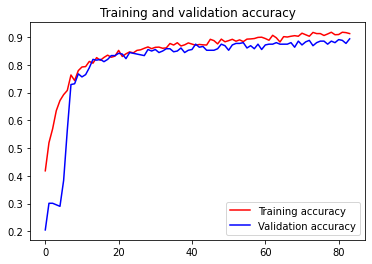

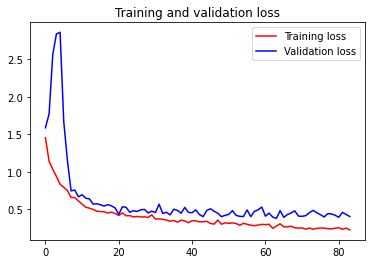

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

Now we load the test set and use model.predict() to obtain classification probabilities.

In [0]:
from PIL import Image
from tqdm.notebook import tqdm
test = pd.read_csv('test.csv')
test_len = test.shape[0]
SIZE=224
PATH = '/content/drive/My Drive/testimages'
test_images = np.empty((test_len, SIZE, SIZE, 3))
for i in tqdm(range(test_len)):
    test_images[i] = np.uint8(Image.open(PATH + f'/Test_{i}.jpg').resize((SIZE, SIZE)))

In [0]:
probabilities = model.predict_generator(validation_generator)
print(probabilities)
print(probabilities[:,0].mean())
print(probabilities[:,1].mean())
print(probabilities[:,2].mean())
print(probabilities[:,3].mean())

[[5.1726343e-04 3.7670370e-02 2.4510613e-03 9.5936126e-01]
 [7.8326768e-01 1.9100519e-03 1.7676409e-03 2.1305466e-01]
 [1.3938356e-05 5.3870538e-03 9.9459887e-01 1.4093808e-07]
 ...
 [3.4907716e-06 2.5585874e-03 9.9743783e-01 9.7248133e-08]
 [2.2050071e-07 9.7963552e-05 9.9990177e-01 5.5611224e-08]
 [8.2247603e-01 5.9221149e-03 6.1843201e-04 1.7098346e-01]]
0.29051396
0.051178757
0.33879197
0.31951532


In [0]:
res = pd.DataFrame()
res['image_id'] = test_ids
res['healthy'] = probabilities[:, 0]
res['multiple_diseases'] = probabilities[:, 1]
res['rust'] = probabilities[:, 2]
res['scab'] = probabilities[:, 3]

AttributeError: ignored

In [0]:
res.to_csv('submission.csv', index=False)